# Overview of Penmanshiel Wind Farm Data 

### Introduction

This Jupyter notebook aims to perform exploratory data analysis (EDA) on turbine data collected from the Penmanshiel wind farm. 
Penmanshiel wind farm data includes multiple csv files of 10-minute SCADA and events data from the 14 Senvion MM82's at Penmanshiel wind farm, grouped by year from 2016 to mid-2021. 


### Dataset Overview

**Date and Time:** Timestamp of the data record.
**Wind Speed (m/s):** The speed of the wind at the turbine location.
**Wind Speed, Standard Deviation (m/s):** Standard deviation of the wind speed.
**Wind Speed, Minimum (m/s):** Minimum recorded wind speed.
**Wind Speed, Maximum (m/s):** Maximum recorded wind speed.
**Long Term Wind (m/s):** Long-term wind speed.
**Rotor Speed (RPM):** Speed of the turbine rotor.
**Generator RPM (RPM):** RPM of the generator.
**Gearbox Speed (RPM):** RPM of the gearbox.
**Tower Acceleration X (mm/ss):** Tower acceleration in the X-axis.
**Tower Acceleration Y (mm/ss):** Tower acceleration in the Y-axis.
**Equivalent Full Load Hours (s):** Equivalent full load hours.

### Exploratory Analysis

This notebook explores various aspects of the turbine data, including visualizations of wind speed, rotor speed, tower acceleration, and other relevant parameters. Different plots and charts are employed to provide insights into the behavior and performance of the turbine during the specified time interval.

**Note:** The analysis presented here is based on a subset of the  dataset. Additional CSV files with similar structures but different values are part of the complete dataset.
Note not all signals are available for the entire period, and there is no turbine WT03.

### Notebook Structure ###

In the first section, we will explore the data for Turbine 1 only using  Turbine_Data_Penmanshiel_01_2021-01-01_-_2022-01-01_1042.csv file. Next, we will load the location information from the Penmanshiel_WT_static.csv file for analysis. In the last section, we will be investigating all 14 turbines for the same time period using the corresponding 'Turbine_Data_Penmanshiel_' files. The file names used in imports match those in the dataset and can be downloaded accordingly. 
    


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import geopandas as gpd
print("Setup Complete")


Setup Complete


## Investigating Turbine 1 

## Wind Speed Over Time for Turbine 1

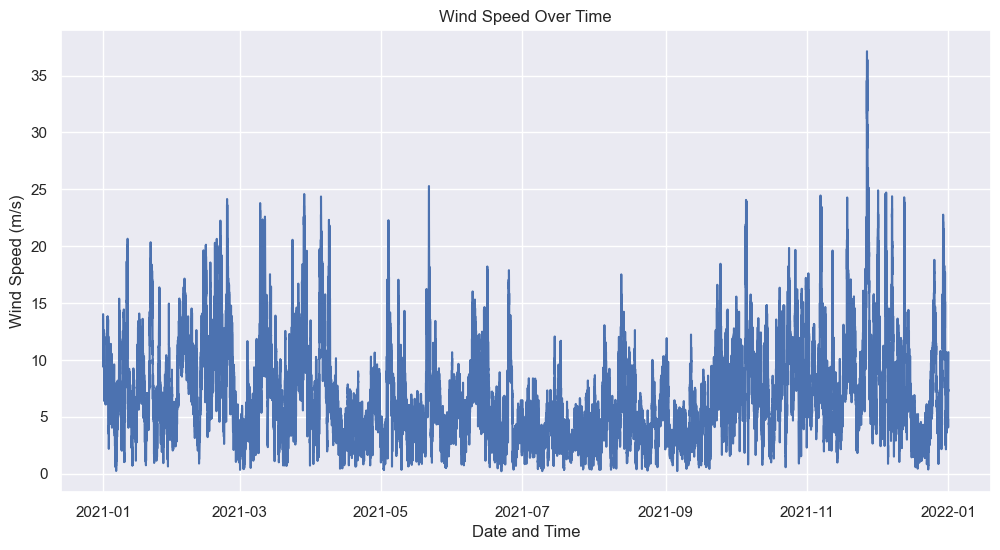

In [53]:
file_path = '../files/'
df = pd.read_csv(f'{file_path}Turbine_Data_Penmanshiel_01_2021-01-01_-_2022-01-01_1042.csv', skiprows=9, parse_dates=['# Date and time'])  # skip the empty top rows
df.head()

plt.figure(figsize=(12, 6))
sns.lineplot(x='# Date and time', y='Wind speed (m/s)', data=df)  # Replace space with underscore
plt.title('Wind Speed Over Time')
plt.xlabel('Date and Time')
plt.ylabel('Wind Speed (m/s)')
plt.grid(True)
plt.show()

## Wind Speed Distribution by Direction

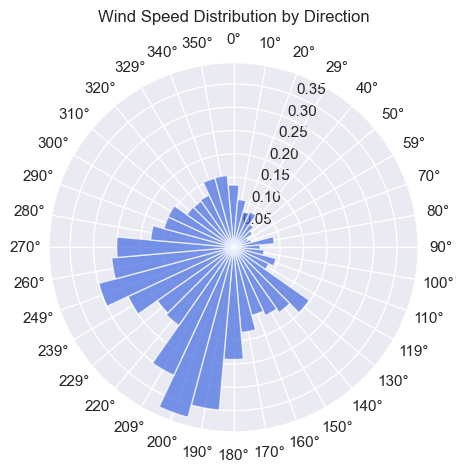

In [54]:
file_path = '../files/'
df = pd.read_csv(f'{file_path}Turbine_Data_Penmanshiel_01_2021-01-01_-_2022-01-01_1042.csv', skiprows=9)

# Check for and drop rows with NaN values in relevant columns
df.dropna(subset=['Wind direction (°)', 'Wind speed (m/s)'], inplace=True)

# Convert wind direction from degrees to radians
wind_direction_radians = np.radians(df['Wind direction (°)'].values)

# Define the bins for the histogram
num_bins = 36
theta = np.linspace(0.0, 2 * np.pi, num_bins + 1)

# Calculate the weighted histogram
radii, _ = np.histogram(wind_direction_radians, bins=theta, weights=df['Wind speed (m/s)'].values, density=True)
width = (2 * np.pi) / num_bins

# Plotting the polar plot
ax = plt.subplot(111, polar=True)
bars = ax.bar(theta[:-1], radii, width=width, color='royalblue', alpha=0.7)

# Set the zero direction and the direction of rotation
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)

# Customize the plot
ax.set_xticks(theta[:-1])
ax.set_xticklabels([f'{int(angle * 180 / np.pi)}°' for angle in theta[:-1]])
ax.set_title('Wind Speed Distribution by Direction', va='bottom')
plt.show()


### Wind Speed Statistics

In [55]:
statistics = df['Wind speed (m/s)'].describe()
print(statistics)

count    52497.000000
mean         6.792844
std          4.034878
min          0.216313
25%          3.938600
50%          5.904035
75%          8.822375
max         37.138613
Name: Wind speed (m/s), dtype: float64


## Plotting the Wind Power Curve Against Wind Speed

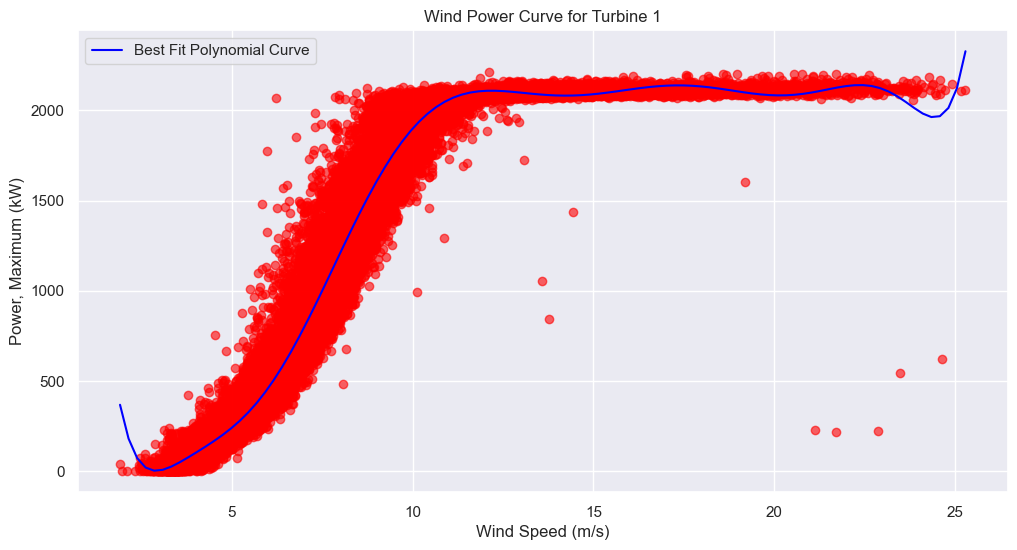

In [56]:

# First, filter out the data points where wind speed is between 5 and 25 m/s and power is zero
df_filtered = df[~((df['Wind speed (m/s)'] >= 5) & (df['Wind speed (m/s)'] <= 25) & (df['Power, Maximum (kW)'] == 0))]

# Now filter out zero or NaN values from both 'Wind speed (m/s)' and 'Power, Maximum (kW)'
df_filtered = df_filtered[(df_filtered['Wind speed (m/s)'] > 0) & (df_filtered['Power, Maximum (kW)'] > 0)]
df_filtered.dropna(subset=['Wind speed (m/s)', 'Power, Maximum (kW)'], inplace=True)

# Plot the cleaned data
plt.figure(figsize=(12, 6))
plt.scatter(df_filtered['Wind speed (m/s)'], df_filtered['Power, Maximum (kW)'], color='red', alpha=0.6)

# Fitting a polynomial curve to the data
# Defining the degree of the polynomial
degree = 10
coefficients = np.polyfit(df_filtered['Wind speed (m/s)'], df_filtered['Power, Maximum (kW)'], degree)
polynomial = np.poly1d(coefficients)

# Generating x values for plotting the polynomial curve
x_values = np.linspace(df_filtered['Wind speed (m/s)'].min(), df_filtered['Wind speed (m/s)'].max(), 100)
y_values = polynomial(x_values)

# Plot the polynomial curve
plt.plot(x_values, y_values, label='Best Fit Polynomial Curve', color='blue')

# Customize the plot
plt.title('Wind Power Curve for Turbine 1')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power, Maximum (kW)')
plt.grid(True)
plt.legend()
plt.show()


### Comparison of Sensors 1 and 2 

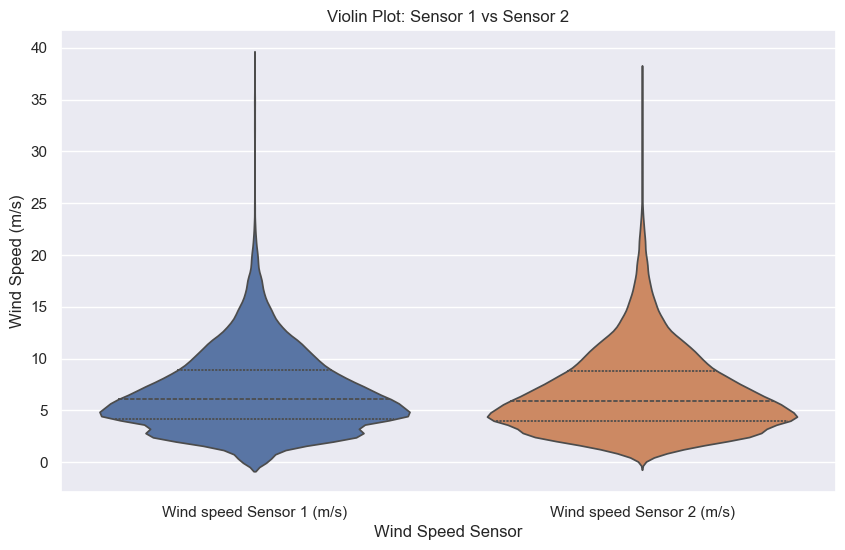

In [57]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df[['Wind speed Sensor 1 (m/s)', 'Wind speed Sensor 2 (m/s)']], inner="quartile")
plt.title('Violin Plot: Sensor 1 vs Sensor 2')
plt.xlabel('Wind Speed Sensor')
plt.ylabel('Wind Speed (m/s)')
plt.show()

### Distribution of Wind Direction

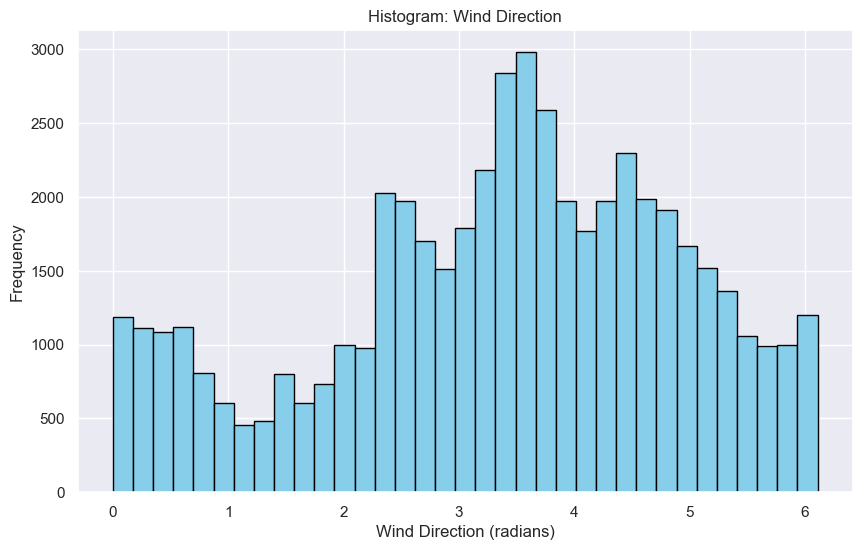

In [58]:
plt.figure(figsize=(10, 6))

plt.hist(np.deg2rad(df['Wind direction (°)']), bins=np.arange(0, 2 * np.pi, np.pi / 18), color='skyblue', edgecolor='black')
plt.title('Histogram: Wind Direction')
plt.xlabel('Wind Direction (radians)')
plt.ylabel('Frequency')
plt.show()

### Statistics of Wind Direction

In [59]:
statistics = df['Wind direction (°)'].describe()
print(statistics)

count    52497.000000
mean       196.919826
std         90.493528
min          0.008944
25%        140.704836
50%        204.112104
75%        264.076566
max        359.998683
Name: Wind direction (°), dtype: float64


## Distribution of Energy Export 

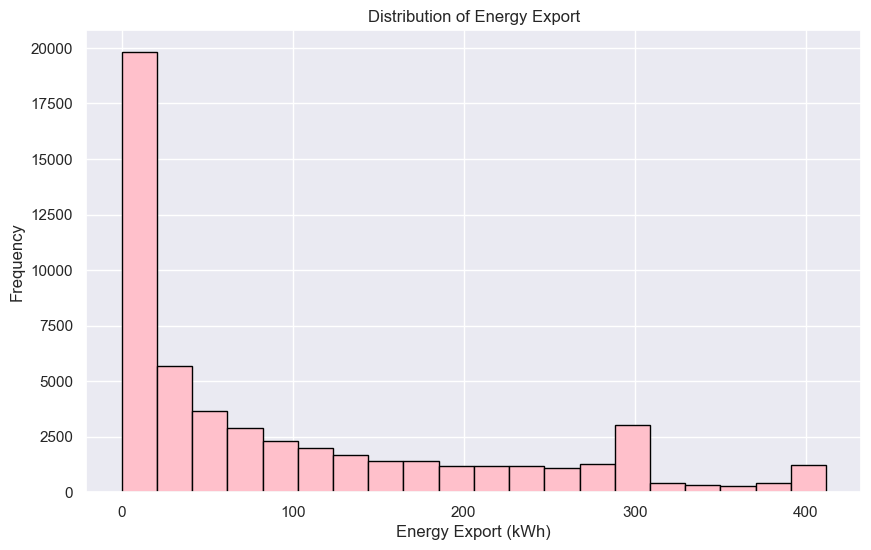

In [60]:
plt.figure(figsize=(10, 6))
plt.hist(df['Energy Export (kWh)'], bins=20, color='pink', edgecolor='black')
plt.title('Distribution of Energy Export')
plt.xlabel('Energy Export (kWh)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Statistics of Energy Export 

In [61]:
statistics = df['Lost Production Total (kWh)'].describe()
print(statistics)

count    52497.000000
mean         1.980046
std         25.893137
min       -343.823981
25%         -3.140196
50%          0.000000
75%          2.681943
max        341.546667
Name: Lost Production Total (kWh), dtype: float64


## Power Distribution

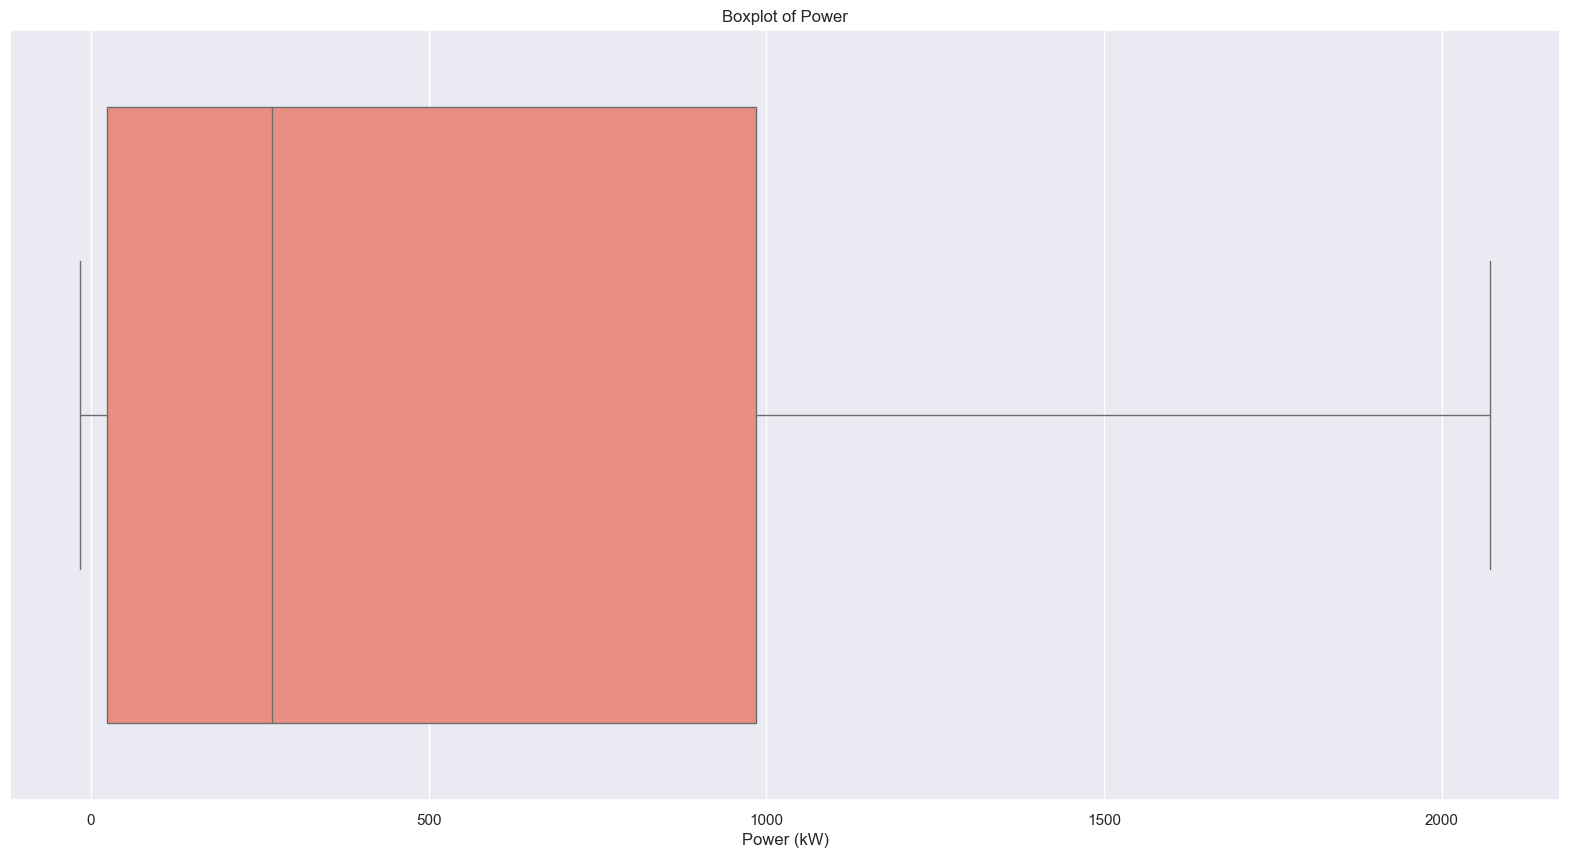

In [62]:
plt.figure(figsize=(20, 10))
sns.boxplot(x=df['Power (kW)'], color='salmon')
plt.title('Boxplot of Power')
plt.xlabel('Power (kW)')
plt.show()

### Statistics of Power

In [63]:
statistics = df['Power (kW)'].describe()
print(statistics)

count    52497.000000
mean       580.973901
std        673.070961
min        -15.420000
25%         24.185639
50%        268.696868
75%        984.135878
max       2070.559920
Name: Power (kW), dtype: float64


## Temperature Readings Over Time

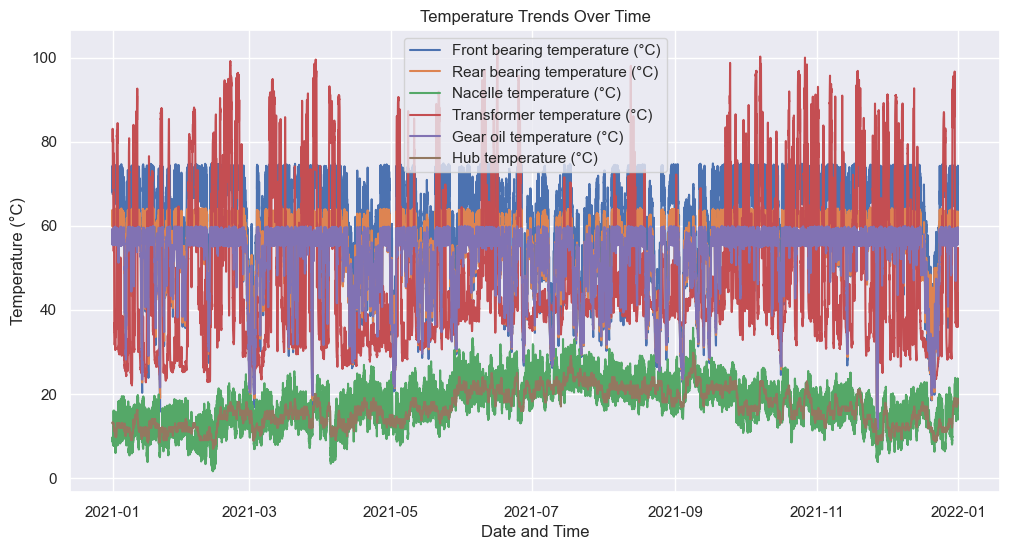

In [66]:
df = pd.read_csv(f'{file_path}Turbine_Data_Penmanshiel_01_2021-01-01_-_2022-01-01_1042.csv', skiprows=9, parse_dates=['# Date and time'])  # skip the empty top rows
temperature_columns = [
    'Front bearing temperature (°C)',
    'Rear bearing temperature (°C)',
    'Nacelle temperature (°C)',
    'Transformer temperature (°C)',
    'Gear oil temperature (°C)',
    'Hub temperature (°C)'
]

plt.figure(figsize=(12, 6))

# Line plot for temperature columns over time (assuming Date_and_time is your time column)
for column in temperature_columns:
    sns.lineplot(x='# Date and time', y=column, data=df, label=column)

plt.title('Temperature Trends Over Time')
plt.xlabel('Date and Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

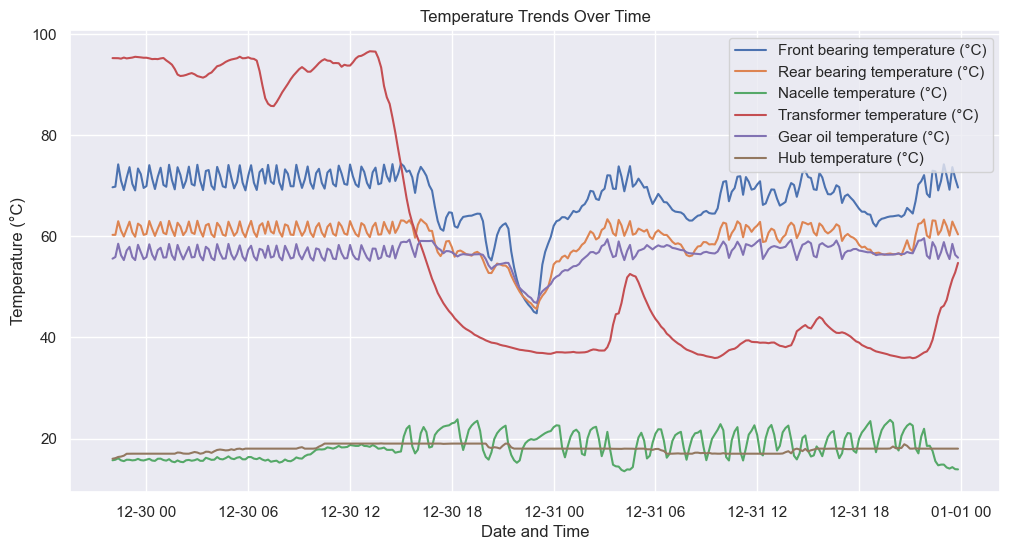

In [67]:
df_last_300 = df.tail(300)

temperature_columns = [
    'Front bearing temperature (°C)',
    'Rear bearing temperature (°C)',
    'Nacelle temperature (°C)',
    'Transformer temperature (°C)',
    'Gear oil temperature (°C)',
    'Hub temperature (°C)'
]

plt.figure(figsize=(12, 6))

# Line plot for temperature columns over time (assuming Date_and_time is your time column)
for column in temperature_columns:
    sns.lineplot(x='# Date and time', y=column, data=df_last_300, label=column)

plt.title('Temperature Trends Over Time')
plt.xlabel('Date and Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

## Statistics of Grid Voltage

In [68]:
statistics = df['Grid voltage (V)'].describe()
print(statistics)

count    52497.000000
mean       407.647725
std         21.987006
min         50.002750
25%        404.342553
50%        405.493678
75%        407.816522
max        712.229980
Name: Grid voltage (V), dtype: float64


## Statistics of Grid Current 

In [69]:
statistics = df['Grid current (A)'].describe()
print(statistics)

count    52497.000000
mean       486.711222
std        542.629023
min          4.887556
25%         51.164000
50%        235.363779
75%        814.022166
max       1691.487488
Name: Grid current (A), dtype: float64


## Statistics of Grid Frequency

In [70]:
statistics = df['Grid frequency (Hz)'].describe()
print(statistics)

count    52497.000000
mean        49.990494
std          0.230078
min          6.245100
25%         49.951546
50%         49.990530
75%         50.031286
max         50.180099
Name: Grid frequency (Hz), dtype: float64


## Speed Distribution (RPM)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


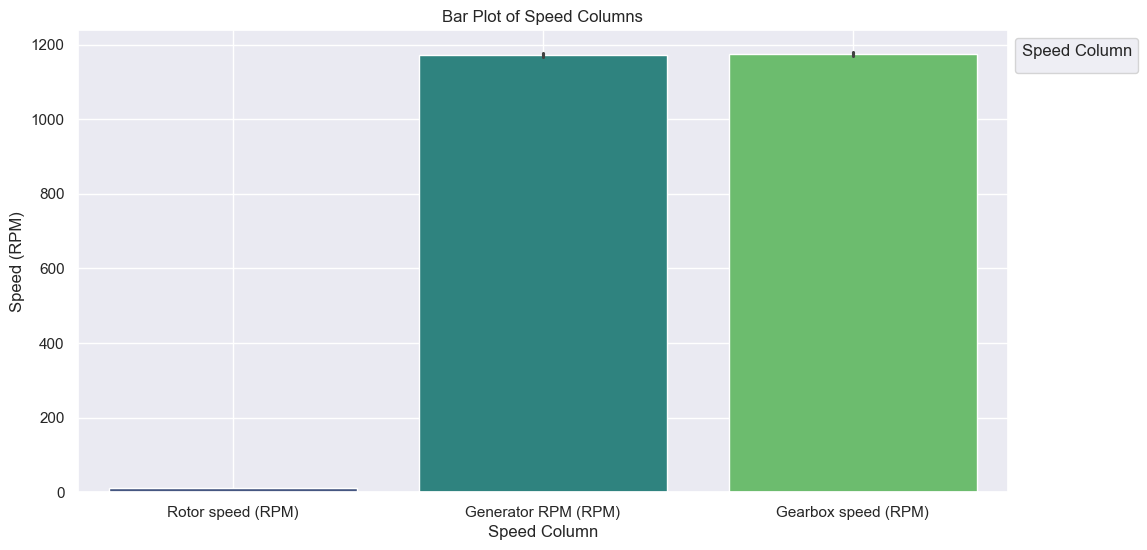

In [71]:
speed_columns = ['Rotor speed (RPM)', 'Generator RPM (RPM)', 'Gearbox speed (RPM)']
plt.figure(figsize=(12, 6))

# Bar plot for speed columns without time
sns.barplot(data=df.melt(id_vars='# Date and time', value_vars=speed_columns),
            x='variable', y='value', hue='variable', palette='viridis')

plt.title('Bar Plot of Speed Columns')
plt.xlabel('Speed Column')
plt.ylabel('Speed (RPM)')
plt.legend(title='Speed Column', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

## Distribution of Full Load Hours

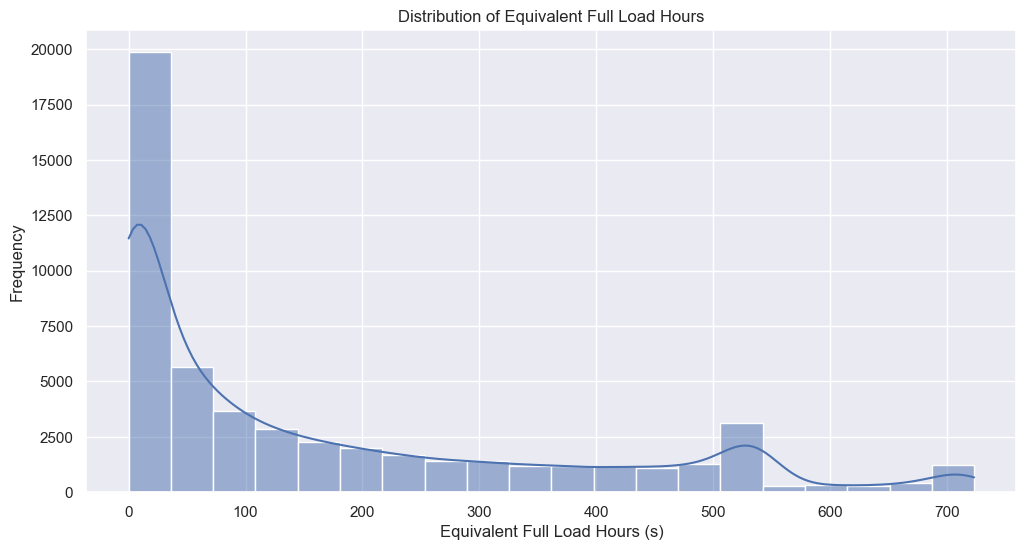

In [72]:
plt.figure(figsize=(12, 6))
sns.histplot(x='Equivalent Full Load Hours (s)', data=df, bins=20, kde=True)
plt.title('Distribution of Equivalent Full Load Hours')
plt.xlabel('Equivalent Full Load Hours (s)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Tower Acceleration in X and Y

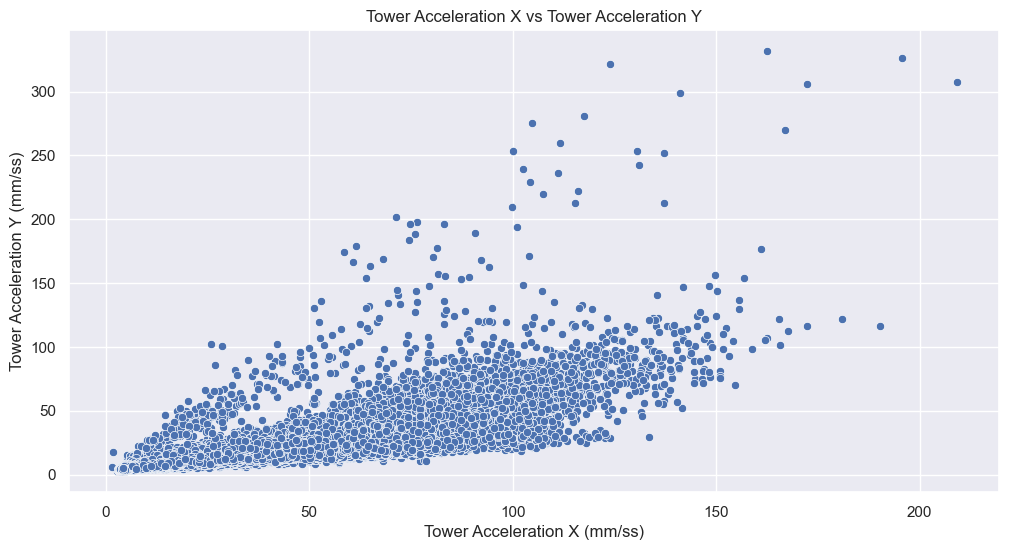

In [73]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Tower Acceleration X (mm/ss)', y='Tower Acceleration y (mm/ss)', data=df)
plt.title('Tower Acceleration X vs Tower Acceleration Y')
plt.xlabel('Tower Acceleration X (mm/ss)')
plt.ylabel('Tower Acceleration Y (mm/ss)')
plt.grid(True)
plt.show()

## Missing Values 

In [74]:
missing_values = df.isnull().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
# Date and time                                0
Wind speed (m/s)                              63
Wind speed, Standard deviation (m/s)         226
Wind speed, Minimum (m/s)                    226
Wind speed, Maximum (m/s)                    226
                                           ...  
Torque set point, StdDev (Nm)              52560
Converter generator torque, Max (Nm)       52560
Converter generator torque, Min (Nm)       52560
Converter generator torque (Nm)            52560
Converter generator torque, StdDev (Nm)    52560
Length: 363, dtype: int64


# Investigating All 14 Turbines 

## Loading Location Data for All Turbines 

In [75]:
df_loc = pd.read_csv(f'{file_path}Penmanshiel_WT_static.csv')[['Title', 'Latitude', 'Longitude', 'Elevation (m)']].iloc[0:14]
df_loc

Title   Latitude  Longitude  Elevation (m)
0   Penmanshiel 01  55.902502  -2.306389         212.26
1   Penmanshiel 02  55.900008  -2.301268         200.46
2   Penmanshiel 04  55.905943  -2.302690         208.91
3   Penmanshiel 05  55.903294  -2.298367         201.38
4   Penmanshiel 06  55.900951  -2.293967         199.03
5   Penmanshiel 07  55.898741  -2.289856         180.24
6   Penmanshiel 08  55.907915  -2.297314         200.13
7   Penmanshiel 09  55.904990  -2.291806         187.04
8   Penmanshiel 10  55.903032  -2.287585         186.88
9   Penmanshiel 11  55.900852  -2.282371         204.84
10  Penmanshiel 12  55.908703  -2.290986         219.31
11  Penmanshiel 13  55.907026  -2.285887         220.00
12  Penmanshiel 14  55.905050  -2.281650         219.46
13  Penmanshiel 15  55.902463  -2.277329         228.15

## Calculating Mean Wind Speeds for Each Turbine 

In [76]:

file_path = '../files/'
filenames = [
    "Turbine_Data_Penmanshiel_01_2021-01-01_-_2022-01-01_1042.csv",
    "Turbine_Data_Penmanshiel_02_2021-01-01_-_2022-01-01_1043.csv",
    "Turbine_Data_Penmanshiel_04_2021-01-01_-_2022-01-01_1044.csv",
    "Turbine_Data_Penmanshiel_05_2021-01-01_-_2022-01-01_1045.csv",
    "Turbine_Data_Penmanshiel_06_2021-01-01_-_2022-01-01_1046.csv",
    "Turbine_Data_Penmanshiel_07_2021-01-01_-_2022-01-01_1047.csv",
    "Turbine_Data_Penmanshiel_08_2021-01-01_-_2022-01-01_1048.csv",
    "Turbine_Data_Penmanshiel_09_2021-01-01_-_2022-01-01_1049.csv",
    "Turbine_Data_Penmanshiel_10_2021-01-01_-_2022-01-01_1050.csv",
    "Turbine_Data_Penmanshiel_11_2021-01-01_-_2022-01-01_1051.csv",
    "Turbine_Data_Penmanshiel_12_2021-01-01_-_2022-01-01_1052.csv",
    "Turbine_Data_Penmanshiel_13_2021-01-01_-_2022-01-01_1053.csv",
    "Turbine_Data_Penmanshiel_14_2021-01-01_-_2022-01-01_1054.csv",
    "Turbine_Data_Penmanshiel_15_2021-01-01_-_2022-01-01_1056.csv"
]

# Initialize a list to store mean wind speed for each turbine
mean_wind_speeds_list = []

for filename in filenames:
    # Construct the full file path
    full_path = f"{file_path}{filename}"
    
    # Read the 'Wind speed (m/s)' column, skipping the initial rows
    df = pd.read_csv(full_path, skiprows=9, parse_dates=['# Date and time'])
    
    # Calculate the mean wind speed and append it to the list
    mean_wind_speeds_list.append(df['Wind speed (m/s)'].mean())

# Create a DataFrame from the list of mean wind speeds
mean_wind_speeds_df = pd.DataFrame(mean_wind_speeds_list, columns=['Mean Wind Speed (m/s)'])

# Optional: save this DataFrame to a CSV file:
mean_wind_speeds_df.to_csv(f'{file_path}mean_wind_speeds.csv', index=False)

df_loc['Mean Wind Speed (m/s)'] = mean_wind_speeds_df['Mean Wind Speed (m/s)']

# Print new df_loc which now has the mean wind speeds as a new column
df_loc

Title   Latitude  Longitude  Elevation (m)  Mean Wind Speed (m/s)
0   Penmanshiel 01  55.902502  -2.306389         212.26               6.792844
1   Penmanshiel 02  55.900008  -2.301268         200.46               6.851601
2   Penmanshiel 04  55.905943  -2.302690         208.91               6.659530
3   Penmanshiel 05  55.903294  -2.298367         201.38               6.556313
4   Penmanshiel 06  55.900951  -2.293967         199.03               6.480745
5   Penmanshiel 07  55.898741  -2.289856         180.24               6.174422
6   Penmanshiel 08  55.907915  -2.297314         200.13               6.783953
7   Penmanshiel 09  55.904990  -2.291806         187.04               6.043535
8   Penmanshiel 10  55.903032  -2.287585         186.88               6.144849
9   Penmanshiel 11  55.900852  -2.282371         204.84               6.612054
10  Penmanshiel 12  55.908703  -2.290986         219.31               6.961278
11  Penmanshiel 13  55.907026  -2.285887         220.00               6.945346
12  Penmanshiel 14  55.905050  -2.281650         219.46               6.869551
13  Penmanshiel 15  55.902463  -2.277329         228.15               6.808728

## Investigating Correlation between Elevation and Mean Wind Speed

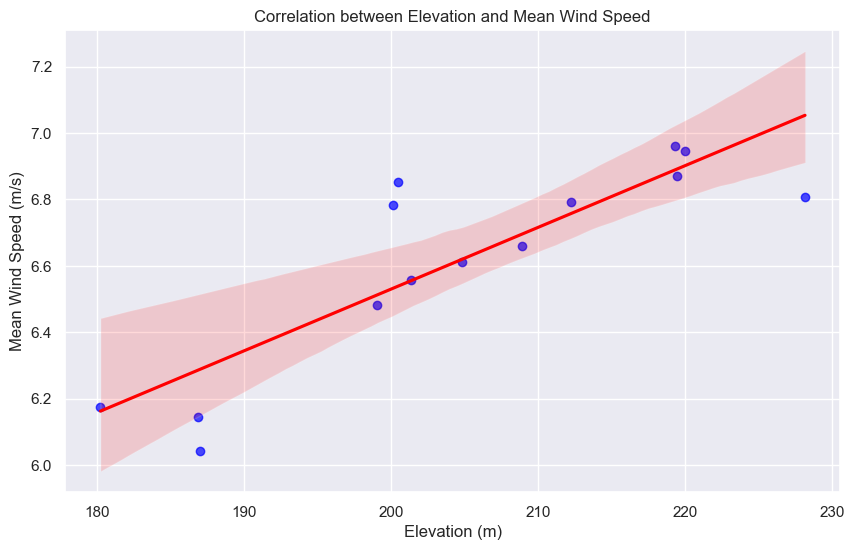

In [78]:

sns.set_theme()

# Create a scatter plot of Elevation vs. Mean Wind Speed
plt.figure(figsize=(10, 6))
plt.scatter(df_loc['Elevation (m)'], df_loc['Mean Wind Speed (m/s)'], color='blue', alpha=0.7)

# Adding a trend line
sns.regplot(x='Elevation (m)', y='Mean Wind Speed (m/s)', data=df_loc, scatter=False, color='red')

plt.title('Correlation between Elevation and Mean Wind Speed')
plt.xlabel('Elevation (m)')
plt.ylabel('Mean Wind Speed (m/s)')
plt.grid(True)
plt.show()


## Visualising Layout of Wind Farm

Here, each turbine is represented as a point with its color indicating the mean wind speed. 

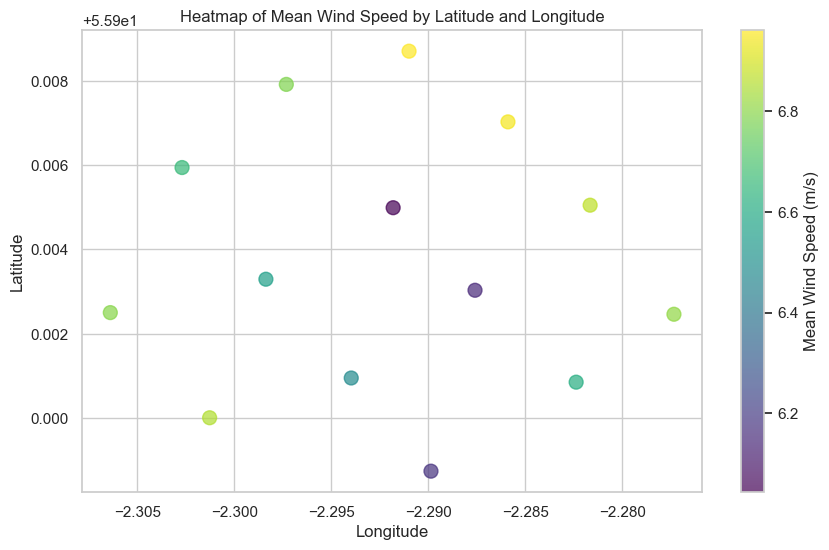

In [21]:
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
plt.scatter(df_loc['Longitude'], df_loc['Latitude'], 
            c=df_loc['Mean Wind Speed (m/s)'], cmap='viridis', 
            s=100, # Adjusts the size of each point
            alpha=0.7) # Makes each point semi-transparent

# Adding a color bar to interpret mean wind speed coloring
plt.colorbar(label='Mean Wind Speed (m/s)')

plt.title('Heatmap of Mean Wind Speed by Latitude and Longitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

Adding contour lines for elavation 

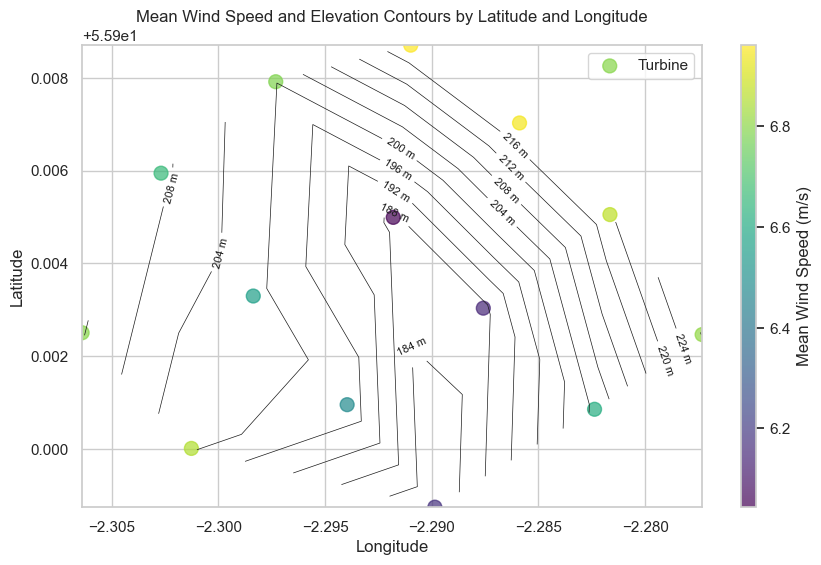

In [72]:
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))

sc = plt.scatter(df_loc['Longitude'], df_loc['Latitude'], 
                 c=df_loc['Mean Wind Speed (m/s)'], cmap='viridis', 
                 s=100, alpha=0.7, label='Turbine')

cbar = plt.colorbar(sc, aspect=30)
cbar.set_label('Mean Wind Speed (m/s)')

# Add contour lines for elevation
contours = plt.tricontour(df_loc['Longitude'], df_loc['Latitude'], df_loc['Elevation (m)'], 
                          levels=14, linewidths=0.5, colors='k')
plt.clabel(contours, inline=True, fontsize=8, fmt='%1.0f m')

plt.title('Mean Wind Speed and Elevation Contours by Latitude and Longitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()

## Mapping the Correlation Between Wind Speed and Wind Direction

<Figure size 1200x1000 with 0 Axes>

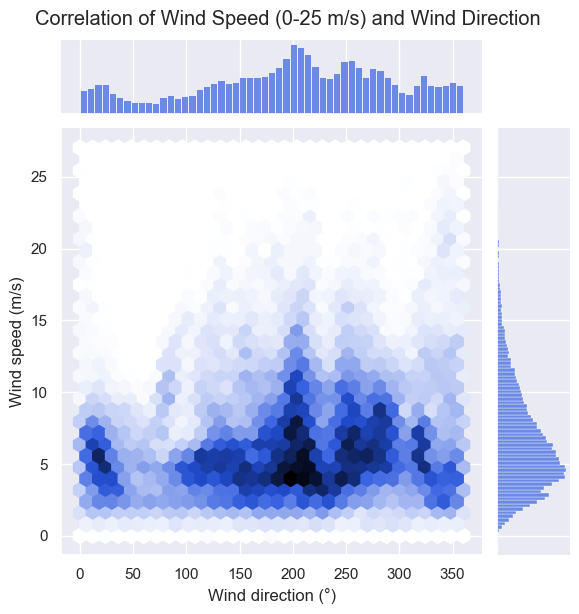

In [77]:

file_path = '../files/'
df_wind = pd.read_csv(f'{file_path}Turbine_Data_Penmanshiel_01_2021-01-01_-_2022-01-01_1042.csv', skiprows=9, parse_dates=['# Date and time'])  # skip the empty top rows
df.head()

df_filtered = df[(df_wind['Wind speed (m/s)'] >= 0) & (df_wind['Wind speed (m/s)'] <= 25)]

plt.figure(figsize=(12, 10))
sns.jointplot(x='Wind direction (°)', y='Wind speed (m/s)', data=df_filtered, kind="hex", color="royalblue", gridsize=30)
plt.suptitle('Correlation of Wind Speed (0-25 m/s) and Wind Direction', y=1.02)
plt.show()

